In [97]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from thefuzz import fuzz
%matplotlib inline

In [69]:
df = pd.read_csv("glassdoor_jobs.csv")
df = df.iloc[:, 1:]
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors'],
      dtype='object')

## data cleaning and parsing

In [70]:
# salary parsing
df = df[df['Salary Estimate'] != "-1"]
salary = df["Salary Estimate"].apply(lambda x: x.split('(')[0])
salary = salary.apply(lambda x: x.replace('K', '').replace('$', ''))
df['hourly_salary'] = df['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
salary= salary.apply(lambda x: x.lower().replace('per hour', '').replace('employer provided salary:', ''))
df['min_salary'] = salary.apply(lambda x: int(x.split('-')[0]))
df['max_salary'] = salary.apply(lambda x: int(x.split('-')[1]))
df['average_salary'] = (df.min_salary + df.max_salary) / 2

In [71]:
# company name (text only)
company_names = df['Company Name'].apply(lambda x: re.sub(r'\d+\.\d+$', '', x))
df['company_name'] = company_names.apply(lambda x: x.strip())

In [72]:
# state field
df['job_state'] = df['Location'].str.split(',').str[1].str.strip()
df['job_state'] = df.job_state.apply(lambda x: 'CA' if x.lower() == 'los angeles' else x)
df['same_state'] = 0
df.loc[df['Location'] == df['Headquarters'], 'same_state'] = 1
# df.job_state.value_counts()

In [73]:
# age of company
df['company_age'] = 2023 - df['Founded']
df.loc[df['Founded'] == -1, 'company_age'] = np.nan

In [74]:
# parsing job description
df['r_yn'] = df['Job Description'].apply(lambda x: 1 if re.search("[\b\s\.,]r[\b\s\.,]|rstudio|r.studio", x.lower()) else 0)
df['powerBI_yn'] = df['Job Description'].apply(lambda x: 1 if re.search("powerbi|power.bi", x.lower()) else 0)
skill_list = ['python', 'aws', 'spark', 'tableau', 'matlab', 'excel', 'sql']
for skill in skill_list:
    df[f'{skill}_yn'] = df['Job Description'].apply(lambda x: 1 if skill in x.lower() else 0)


In [75]:
df.powerBI_yn.sum()

56

## Exploratory data analysis

In [76]:
# job title and seniority
def title_simplifier(title):
    i = title.lower()
    if "data scientist" in i or "data science" in i:
        return "data scientist"
    elif "analyst" in i:
        return "data analyst"
    elif "architect" in i:
        return "data architect"
    elif "director" in i:
        return "director"
    elif "machine learning" in i:
        return "machine learning engineer"
    elif "manager" in i or "management" in i:
        return "manager"
    elif "data engineer" in i:
        return "data engineer"
    else:
        return "not specified"
    
def rank(title):
    i = title.lower()
    if "sr" in i or "lead" in i or "principal" in i or "senior" in i:
        return "senior"
    elif "jr" in i or "junior" in i:
        return "junior"
    else:
        return "not specified"


In [77]:
df['job_title'] = df['Job Title'].apply(title_simplifier)
df.job_title.value_counts()

data scientist               313
not specified                161
data engineer                115
data analyst                 102
machine learning engineer     22
manager                       18
director                       8
data architect                 3
Name: job_title, dtype: int64

In [78]:
df['job_rank'] = df['Job Title'].apply(rank)
df.job_rank.value_counts()

not specified    519
senior           220
junior             3
Name: job_rank, dtype: int64

In [79]:
# job description length
df['desc_len'] = df['Job Description'].apply(lambda x: len(x))
df.desc_len

0      2555
1      4828
2      3495
3      3926
4      2748
       ... 
950    6219
951    6167
952    3107
953    1678
955    3710
Name: desc_len, Length: 742, dtype: int64

In [80]:
# competitor count
df['competitors_count'] = 0
df['competitors_count'] = df['Competitors'].apply(lambda x: 0 if x == '-1' else len(x.split(',')))
df.competitors_count

0      0
1      0
2      0
3      3
4      3
      ..
950    3
951    3
952    0
953    0
955    0
Name: competitors_count, Length: 742, dtype: int64

In [99]:
# df['hourly_salary'].sum()

24

<Axes: xlabel='Rating', ylabel='Count'>

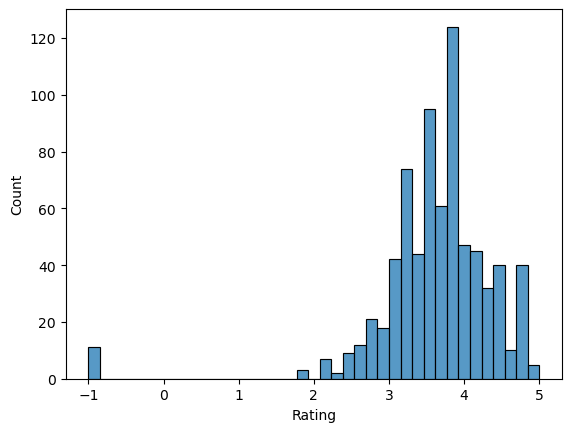

In [98]:
sns.histplot(data = df, x = 'Rating')

<Axes: xlabel='average_salary', ylabel='Count'>

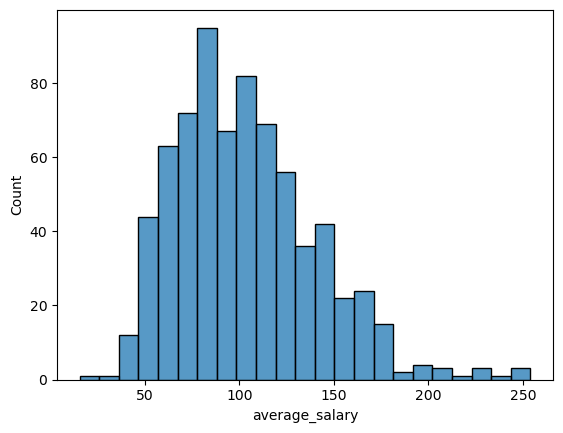

In [85]:
sns.histplot(data = df[df.hourly_salary == 0], x = 'average_salary')

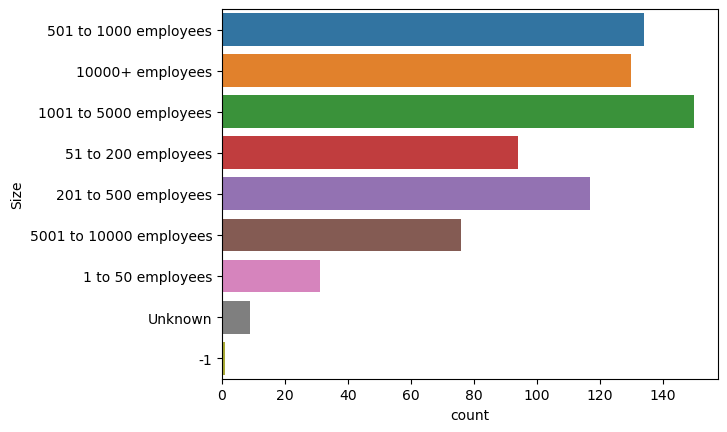

In [96]:
sns.countplot(data = df, y = 'Size')
plt.show()

<Axes: xlabel='average_salary', ylabel='Count'>

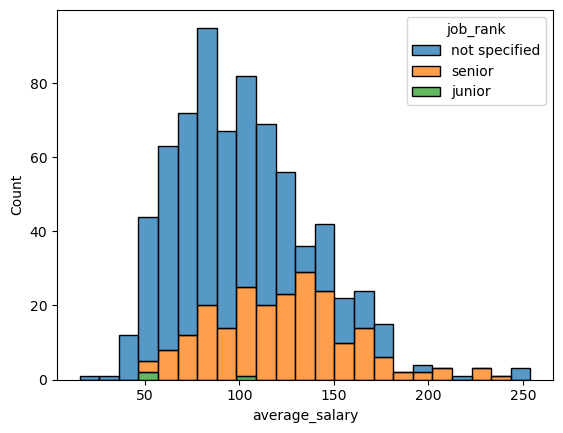

In [102]:
sns.histplot(data = df[df['hourly_salary'] == 0], x = 'average_salary', hue = 'job_rank',\
  multiple = 'stack')

In [86]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly_salary', 'min_salary', 'max_salary', 'average_salary',
       'company_name', 'job_state', 'same_state', 'company_age', 'r_yn',
       'powerBI_yn', 'python_yn', 'aws_yn', 'spark_yn', 'tableau_yn',
       'matlab_yn', 'excel_yn', 'sql_yn', 'job_title', 'job_rank', 'desc_len',
       'competitors_count', 'employee_count'],
      dtype='object')

In [87]:
# fuzzy match didn't work as expected
# job_titles = df['Job Title'].unique()
# # num_titles = len(df['Job Title'].unique())
# job_titles = sorted(job_titles, key = lambda x: len(x))

# matches = []

# for i, title in enumerate(job_titles):
#   if title == '' : continue
#   # match = [title]
#   matches.append(title)
#   for j, role in enumerate(job_titles):
#     if title == role or role == '': 
#       continue
#     elif fuzz.token_set_ratio(title, role) > 90:
#       # match.append(role)
#       job_titles[j] = ''
  
#   job_titles[i] = ''
#   # matches.append(match)

# matches

## Model building